In [4]:
!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-01-10 23:48:27--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  23.6MB/s    in 8.6s    

2021-01-10 23:48:36 (20.1 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-01-10 23:48:36--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  18.0MB/s    in 3.4s    

2021-01-10 23:48:40 (18.0 MB/s) - ‘test_32x32.mat’ saved [64275384/64

Digit Label:  1


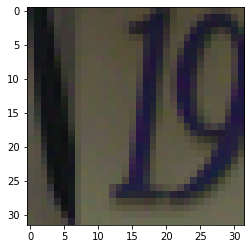

Digit Label:  9


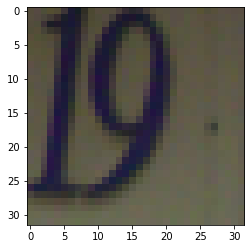

Digit Label:  2


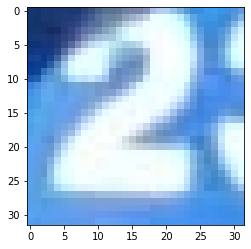

Digit Label:  3


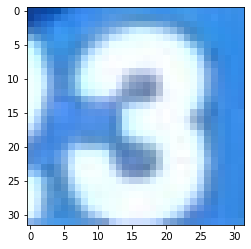

Digit Label:  2


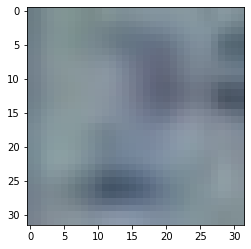

In [3]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

train_X = train['X']
train_y = train['y']
test_y = test['y']

# Replacing all the labels “10“ with label “0”
for i in range(len(train_y)):
  digit = int(train_y[i])
  if(digit == 10):
    train_y[i] = 0

for i in range(len(test_y)):
  digit = int(test_y[i])
  if(digit == 10):
    test_y[i] = 0

# displaying example images
for i in range(5):
  digit = int(train_y[i])
  print('Digit Label: ', digit)
  plt.imshow(train_X[:,:,:,i])
  plt.show()

In [5]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping val2017.zip
Done transferring all datasets


loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
(427, 640, 3)
(256, 192, 3)


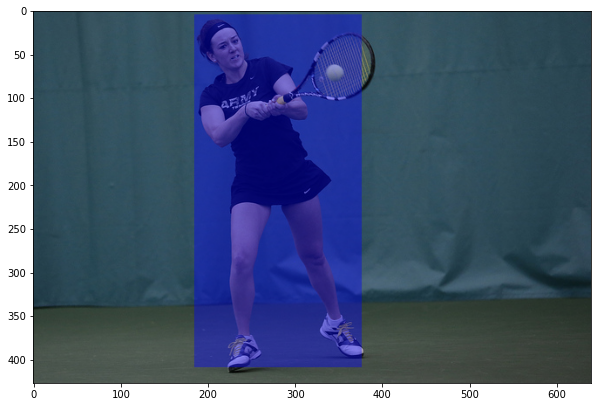

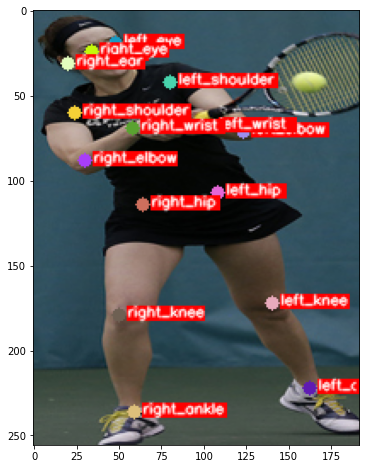

In [7]:
from pycocotools.coco import COCO
import json
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt
import cv2
from PIL import Image

# function to draw keypoints on image
def draw_keypoints(image):
  kp_img = image.copy()
  for idx, k in enumerate(range(len(keypoint_text))):
    x = 'x'+ str(idx)
    y = 'y'+ str(idx)
    v = 'v'+ str(idx)
    text = keypoint_text[idx]
    visible = int(keypoint_df[v])

    rect_width = len(text)*4.6
    rect_height = 5
    
    if(visible == 2):
      
      # adjusted keypoint location in resized image
      adjusted_pt = get_scaled_point(int(keypoint_df[x]),int(keypoint_df[y]))
      pt_x = adjusted_pt[0]
      pt_y = adjusted_pt[1]
      # draw circle at keypoint location
      clr = list(np.random.random(size=3) * 256)
      kp_img = cv2.circle(kp_img, center=(pt_x, pt_y), radius=4, color= clr, thickness= -1)
      # draw background rectangle for text
      pt1 = (int(pt_x+5), int(pt_y+3))
      pt2 = (int((pt_x+4) + rect_width), int(pt_y - rect_height))    
      cv2.rectangle(kp_img, pt1, pt2, color_red, cv2.FILLED)
      # Putting text on keypoints
      pt = (pt_x+5,pt_y+1)
      cv2.putText(kp_img,text, pt, font, scale, color_white, thickness, cv2.LINE_AA)
  
  return kp_img

def get_scaled_point(x,y):
  xy = np.asarray([bbox[0],bbox[1]])
  kp = np.asarray([x,y])
  diff = np.subtract(kp,xy)
  return np.round(diff*scale_factor).astype(int)

# variable initialization
path = '/content/'
kp_json = path + 'annotations/person_keypoints_val2017.json'
bbox,keypoints,kp_cols,kp_list,pts_list,new_bbox_coord = [],[],[],[],[],[]
img_id = 65736
scale = 0.28
font = cv2.FONT_HERSHEY_SIMPLEX
thickness = 1
color_red = (255, 0, 0)
color_white = (255, 255, 255)
color_blue = (0, 0, 255)
alpha = 0.4
resize_h = 256
resize_w = 192

# load annotations using coco api
coco = COCO(kp_json)
img_descriptor = coco.loadImgs(img_id)
gt_ann_ids = coco.getAnnIds(imgIds=[img_id])
gt_anns = coco.loadAnns(gt_ann_ids)

# get image, bounding box, keypoints 
file_name = img_descriptor[0]['file_name']
img = io.imread(path + "val2017/" + file_name)
print(img.shape)

for gt in gt_anns:
  bbox = gt['bbox']
  keypoints = gt['keypoints'] 

# Read keypoints from json file into dataframe
with open(kp_json, "r") as f:
    data = json.load(f)
categories = data['categories']
for cat in categories:
  keypoint_text = cat['keypoints']

for idx, k in enumerate(range(len(keypoint_text))):
  kp_cols.append('x'+ str(idx))
  kp_cols.append('y'+ str(idx))
  kp_cols.append('v'+ str(idx))
keypoint_df = pd.DataFrame(data=[keypoints],columns=kp_cols,index=None)

# show bounding box on image
img_bbox = img.copy() 
img_bbox = cv2.rectangle(img_bbox,(int(bbox[0]),int(bbox[1])),(int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])),color_blue,-1)
img_bbox = cv2.addWeighted(img_bbox, alpha, img, 1 - alpha, 0)
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img_bbox)

# Resize and crop image
scale_factor = np.divide(np.asarray([resize_w,resize_h]), np.asarray([bbox[2],bbox[3]]))
PIL_image = Image.fromarray(img)
resized_img = PIL_image.resize((resize_w,resize_h), box=(int(bbox[0]),int(bbox[1]),int(bbox[0]+bbox[2]),int(bbox[1]+bbox[3])))
np_resized_img = np.array(resized_img)

# draw keypoints
kp_image = draw_keypoints(np_resized_img)
print(kp_image.shape)
# display keypoints on image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(kp_image)
